In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import os
from SLOPER import *

# Load DLPFC

In [7]:
data_dir = "data"
file_folder = "151673"
path = os.path.join(data_dir, file_folder)
adata = sc.read_visium(path,count_file = "filtered_feature_bc_matrix.h5",load_images=True)
adata.var_names_make_unique()
df_meta = pd.read_csv(os.path.join(path, "metadata.tsv"), sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
sc.pp.filter_genes(adata, min_cells=100)
adata.layers["raw_counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
orig_gene = adata.var.index.values

C:\Users\An Wang\AppData\Local\Temp\ipykernel_128992\3806580435.py:4: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(path,count_file = "filtered_feature_bc_matrix.h5",load_images=True)
c:\Users\An Wang\.conda\envs\vae-spatial\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\An Wang\.conda\envs\vae-spatial\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\An Wang\.conda\envs\vae-spatial\lib\site-packages\scanpy\preprocessing\_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


# Normalize coordinate, prepare boundary weights and the push-in projector for boundary correction

In [3]:
coords_t = prepare_coords(adata, file_folder, normalize_coords=True)
t_dists, t_grads, t_bpts,poly = boundary_distances_and_gradients_torch(coords_t,0.005,eps = .1, visualize = False)
projector = build_sdf_projector(poly, H=2048, W=2048, margin=0.5, device="cuda")

# Train SLOPER on individual gene

In [50]:
gene = "PCP4"
weights_t = prepare_weights(adata, gene, a_min = 0)
model = ScoreNet(hidden_dim=64, depth=2, activation="softplus",use_fourier=False)
train(
    model=model,
    coords=coords_t,
    weights=weights_t,
    distances=t_dists,
    grad_g0=t_grads,
    lr=1e-3,
    epochs=3000,
    weights_decay = 1e-4,
    step_size=300,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    gate_alpha=0,
    curl_eta=.5,
    log_every=500)

96.61835479736328 0.0
[Epoch 1/3000] loss = -0.0491
[Epoch 500/3000] loss = -15.1212
[Epoch 1000/3000] loss = -15.7031
[Epoch 1500/3000] loss = -15.7143
[Epoch 2000/3000] loss = -15.7144
[Epoch 2500/3000] loss = -15.7144
[Epoch 3000/3000] loss = -15.7144


# Enhance expression with annealed Langevin dynamics

In [51]:
outs = get_model_outputs(model, coords_t)
gene_idx = list(orig_gene).index(gene)
total_counts = int(np.asarray(adata.layers["raw_counts"].toarray()[:, gene_idx]).sum())
samples = sample_ld_in_polygon_sdf(
    model, projector,
    M=total_counts, 
    T=500, 
    eps=0.15,
    sigma_noise=1.0, alpha=0.999,
    project_every=1, project_iters=1, push_in=1e-3,
    poly=poly
)
enhanced_feature = counts_from_samples_nearest(
                coords_t, samples.detach().cpu(), return_assignments=False
            )

# Utility functions for plotting

In [45]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm as normal
def compute_velocity_on_grid(
    X_emb,
    V_emb,
    density=None,
    smooth=None,
    n_neighbors=None,
    min_mass=None,
    adjust_for_stream=False,
    cutoff_perc=None,
):
    """TODO."""
    # remove invalid cells
    idx_valid = np.isfinite(X_emb.sum(1) + V_emb.sum(1))
    X_emb = X_emb[idx_valid]
    V_emb = V_emb[idx_valid]

    # prepare grid
    n_obs, n_dim = X_emb.shape
    density = 1 if density is None else density
    smooth = 0.5 if smooth is None else smooth

    grs = []
    for dim_i in range(n_dim):
        m, M = np.min(X_emb[:, dim_i]), np.max(X_emb[:, dim_i])
        m = m - 0.01 * np.abs(M - m)
        M = M + 0.01 * np.abs(M - m)
        gr = np.linspace(m, M, int(50 * density))
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    X_grid = np.vstack([i.flat for i in meshes_tuple]).T

    # estimate grid velocities
    if n_neighbors is None:
        n_neighbors = int(n_obs / 50)
    nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
    nn.fit(X_emb)
    dists, neighs = nn.kneighbors(X_grid)

    scale = np.mean([(g[1] - g[0]) for g in grs]) * smooth
    weight = normal.pdf(x=dists, scale=scale)
    p_mass = weight.sum(1)

    V_grid = (V_emb[neighs] * weight[:, :, None]).sum(1)
    V_grid /= np.maximum(1, p_mass)[:, None]
    if min_mass is None:
        min_mass = 1

    if adjust_for_stream:
        X_grid = np.stack([np.unique(X_grid[:, 0]), np.unique(X_grid[:, 1])])
        ns = int(np.sqrt(len(V_grid[:, 0])))
        V_grid = V_grid.T.reshape(2, ns, ns)

        mass = np.sqrt((V_grid**2).sum(0))
        min_mass = 10 ** (min_mass - 6)  # default min_mass = 1e-5
        min_mass = np.clip(min_mass, None, np.max(mass) * 0.9)
        cutoff = mass.reshape(V_grid[0].shape) < min_mass

        if cutoff_perc is None:
            cutoff_perc = 5
        length = np.sum(np.mean(np.abs(V_emb[neighs]), axis=1), axis=1).T
        length = length.reshape(ns, ns)
        cutoff |= length < np.percentile(length, cutoff_perc)

        V_grid[0][cutoff] = np.nan
    else:
        min_mass *= np.percentile(p_mass, 99) / 100
        X_grid, V_grid = X_grid[p_mass > min_mass], V_grid[p_mass > min_mass]

    return X_grid, V_grid
def plot_streamlines_from_scores(
    centers,
    score_model_outputs,
    grid_density=1.0,          # resolution of the interpolation grid (~50*grid_density per axis)
    smooth=0.5,                 # Gaussian kernel width multiplier for smoothing
    n_neighbors=None,           # kNN for local averaging; if None, picked from N
    min_mass=1,                 # use numeric (1 -> ~1e-5 cutoff internally) when adjust_for_stream=True
    cutoff_perc=5,              # mask weakest ~5% regions as extra denoising
    seed_density=1.0,           # streamline seeding density (visual, not grid resolution)
    arrowsize=1.0,
    base_linewidth=1.2,
    scatter_pts=False,
    scatter_s=5,
    scatter_alpha=0.5,
    minlength=0.01,
    axis_off=True,
    counts=None,
    title=None,
    color_bar_name=None
):
    # --- basic checks ---
    centers = np.asarray(centers, dtype=float)
    V = np.asarray(score_model_outputs, dtype=float)
    assert centers.ndim == 2 and centers.shape[1] == 2, "centers must be (N,2)"
    assert V.shape == centers.shape, "score_model_outputs must be (N,2) matching centers"

    N = centers.shape[0]
    if n_neighbors is None:
        # a reasonable default tied to sample size
        n_neighbors = max(10, min(50, N // 50 if N >= 50 else max(10, N // 2)))

    # --- interpolate vectors onto a regular grid, shaped for streamplot ---
    X_grid, V_grid = compute_velocity_on_grid(
        X_emb=centers,
        V_emb=V,
        density=grid_density,
        smooth=smooth,
        n_neighbors=n_neighbors,
        min_mass=min_mass,           # numeric! (1 -> ~1e-5 after transform)
        adjust_for_stream=True,      # returns x,y,u,v in streamplot-friendly shapes
        cutoff_perc=cutoff_perc
    )

    # X_grid: [x_coords (ns,), y_coords (ns,)]
    # V_grid: [u (ns,ns), v (ns,ns)]
    u, v = V_grid[0], V_grid[1]
    speed = np.sqrt(u**2 + v**2)
    max_speed = np.nanmax(speed) if np.any(np.isfinite(speed)) else 1.0

    # thickness scaled by local speed (clip to a nice range)
    lw = base_linewidth * np.nan_to_num(speed / (max_speed + 1e-12))
    # (matplotlib accepts a 2D array for linewidth matching u/v shape)

    # --- plot ---
    fig, ax = plt.subplots(figsize=(6, 7))
    divider = make_axes_locatable(ax)
    if scatter_pts:
        ax.scatter(centers[:, 0], centers[:, 1], s=scatter_s, c="k", alpha=scatter_alpha, zorder=1)
    if counts is not None:
        sc = ax.scatter(
            centers[:, 0], centers[:, 1],
            c= counts, cmap="magma",
            marker="h", s=40, edgecolor='gray', linewidth=0.2,
            zorder=2
        )
        cax = divider.append_axes("bottom", size="6%", pad=0.0)
        cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
        cbar.set_label(
        color_bar_name,
        fontsize=20,          # bigger text
        fontweight="bold",    # bolder
        color="black",        # label color
        labelpad=14,          # push it away from the bar
        rotation=0
    )
        cbar.ax.tick_params(labelsize=18, width=1.5, length=6)
    sp = ax.streamplot(
        X_grid[0], X_grid[1], u, v,
        density=seed_density,
        linewidth=lw,
        color="white",
        arrowsize=arrowsize,
        arrowstyle="-|>",
        maxlength=1000,
        minlength=minlength,
        integration_direction="both",
        zorder=3,
    )

    if axis_off:
        ax.axis("off")
    else:
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect("equal")
    ax.set_title(title, fontdict={'fontsize': 24, 'fontweight': 'bold'})
    ax.invert_yaxis()
    #plt.tight_layout()
    return fig, ax

# Plot enhanced expression and the gradient

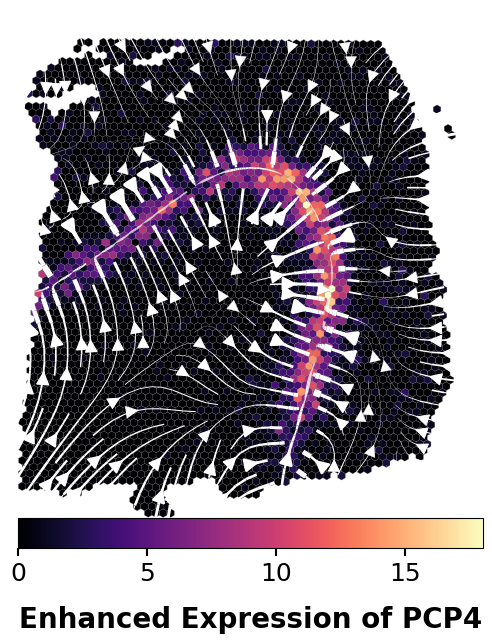

In [ ]:
fig, ax = plot_streamlines_from_scores(
    coords_t,
    outs["score"].detach().cpu().numpy(),
    grid_density=1.0,
    smooth=.5,
    n_neighbors=None,      # auto-choose
    min_mass=1,            # IMPORTANT: numeric when adjust_for_stream=True
    cutoff_perc=0,
    seed_density=1.2,
    arrowsize=2,
    base_linewidth=5.5,
    counts=enhanced_feature,
    #counts = np.log1p(enhanced_feature),
    title="",
    color_bar_name=f"Enhanced Expression of {gene}",
    minlength=0.05
)